In [2]:
import pandas as pd
import sqlite3 as db
import datetime as dt
import numpy as np
import math
import os.path

from scipy import stats
from sklearn.metrics import r2_score,explained_variance_score
from sklearn.cluster import KMeans
from statsmodels.tsa.vector_ar import vecm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

Identifying birds that strongly select for one or more habitats, then analyzing their behavior using a multivariate vector auto-regression

In [2]:
github_userName = 'Tanag3r'
ebird_token = 'j6c7l80ga2ib'
db_name = 'trailheadDirectBirds_sous.db'
path = 'c:\\Users\\lukew\\Documents\\trailheadDirect_repo\\trailheadDirect_birds\\'

In [3]:
##connect to database
def connectDB():
    try:
        db_path = f'{path}{db_name}'
        cnx = db.connect(database=db_path)
    except Exception as cnxError:
        raise UserWarning(f'Unable to connect to database due to: {cnxError}')
    return cnx

In [4]:
##TODO #99 replace the update latestUpdate in the function with a trigger in the database
class notInTable(ValueError):
    def __init__(self,locId,message="given locId cannot be found in table Hotspots"):
        self.locId = locId
        self.message = message
        super().__init__(self.message)
    def __str__(self):
        return f'{self.locId} >> {self.message}'


In [5]:
class emptyReturn(TypeError):
    
    def check_speciesCode(self,speciesCode: str,cnx):
        cursor = cnx.cursor()
        checkQuery = """SELECT EXISTS(SELECT ? FROM historicObservations WHERE speciesCode = ?);"""
        checkTuple = (speciesCode,speciesCode)
        checkResult = cursor.execute(checkQuery,checkTuple).fetchone()[0]
        if checkResult == 0:
            message = f"{speciesCode}: the given species code is not in the database"
        else:
            message = "no values have been returned by the query"
        return message
    def __init__(self,speciesCode,cnx):
        self.speciesCode = speciesCode
        self.cnx = cnx
        self.message = self.check_speciesCode(speciesCode=speciesCode,cnx=cnx)
        super().__init__(self.message)
    def __str__(self):
        return f'{self.check_speciesCode}'  

In [6]:
def post_hotspotHabitat(locId: str,label: int,cnx=connectDB()):
    try:
        cursor = cnx.cursor()
    #validate
        validate_query = "SELECT EXISTS(SELECT ? FROM Hotspots WHERE locId = ?)"
        validate_tuple = (locId,locId)
        cursor.execute(validate_query,validate_tuple)
        validate = cursor.fetchone()[0]
        if validate == 0:
            raise notInTable(locId)
        else:
            updateLabel_script = "UPDATE Hotspots SET habitatLabel = ?, latestUpdate = ? WHERE locId = ?;"
            updatelabel_tuple = (label,str(dt.datetime.today()),locId)
            cursor.execute(updateLabel_script,updatelabel_tuple)
            cnx.commit()
            cursor.close()
    except ValueError as vxf:
        raise vxf
    except Exception as ex:
        raise ex
    return locId

In [7]:
#derive habitat cluster labels from FAO values using k-means
def kmeans_habitat(distinctHabitats: int,cnx= connectDB()):
    try:
        data = pd.read_sql(sql='SELECT * FROM FAO_by_locId;',con=cnx)
        data = data.drop(columns=['locName']).set_index('locId')
        data.fillna(0,inplace=True)
    #normalize
        maxValue = data.apply(max,axis=1)
        data = data.apply(lambda x: (x/maxValue[x.index]),axis=0)   #min-max normalizing to smooth in proportionality
    #compute kmeans for each locId
        habitat_kmeans = KMeans(n_clusters=distinctHabitats,init='k-means++')
        habitat_kmeans = habitat_kmeans.fit(data.values)
        clusterLabels = habitat_kmeans.labels_
        centerPoints = habitat_kmeans.cluster_centers_
    #define habitats
        habitatFrame = pd.DataFrame(data=clusterLabels,columns=['clusterLabel'],index=data.index).sort_values(by='clusterLabel').reset_index()
        #habitatFrame = pd.merge(left=habitatFrame,left_on='locId',right=data,right_on='locId',how='left')
    except Exception as kmeansExc:
        raise kmeansExc
    return habitatFrame,centerPoints

In [115]:
def build_datebase(speciesCode,con = connectDB()):
    try:
        cursor = con.cursor()
        minDateQuery = f"""select date(obsDt) as "startDate" from historicObservations group by speciesCode having obsDt=min(obsDt) and speciesCode = '{speciesCode}';"""
        maxDateQuery = f"""select date(obsDt) as "stopDate" from historicObservations group by speciesCode having obsDt=max(obsDt) and speciesCode = '{speciesCode}';"""
        validate = cursor.execute(minDateQuery).fetchone()
        if validate is None:
            raise emptyReturn(speciesCode=speciesCode,cnx=con)
        else:
            minDate = cursor.execute(minDateQuery).fetchone()[0]
            minDate = dt.datetime.strptime(minDate,'%Y-%m-%d')
            minDate = minDate + pd.offsets.Week(-5)
            maxDate = cursor.execute(maxDateQuery).fetchone()[0]
            maxDate = dt.datetime.strptime(maxDate,'%Y-%m-%d')
            maxDate = maxDate + pd.offsets.Week(5)
            datebase = []
            for i in pd.date_range(start=minDate,end=maxDate,freq='W',name='obsDt'):
                datebase.append(i)
    except Exception as ex:
        raise ex
    return pd.Series(datebase,name='obsDt')

Feature development

In [275]:
##TODO #100 write a function to test for seasonal preference with a scaling lead-lag scope dependent on volume of observations available
def feature_selectionRatio(speciesCode: str,habitatLabel: int,con = connectDB()):
	try:
		cursor = con.cursor()
		query = f"""with habitatAbundance as (
		select
			date(obsDt) as "obsDt",
			(strftime('%Y',obsDt)||'-'||strftime('%W',obsDt)) as "year_week",
			round(avg(howMany),3) as "habitatVolume",
			(total(round(avg(howMany),3)) over(partition by strftime('%Y',obsDt)||'-'||strftime('%W',obsDt))) as "volume_allHabitats",
			(avg(howMany) over(PARTITION BY strftime('%Y',obsDt))) as "annualAvgAbd",
			habitatLabel 
		from historicObservations as hsob
		left join (select locId,habitatLabel from Hotspots) as "labels" on hsob.locId=labels.locId
		where speciesCode = '{speciesCode}'
		group by year_week,habitatLabel
		)
		select obsDt,
		--year_week,
		habitatLabel,
		--selection ratio as a function of weekly observations
		round((habitatVolume/volume_allHabitats),3) as "weekly_selectionRatio",
		--selection ratio as a function of the annual relative abundance
		round((habitatVolume/annualAvgAbd),3) as "annual_selectionRatio"
		from habitatAbundance
		where habitatLabel = {habitatLabel}
		order by obsDt asc
		;"""
		validate = cursor.execute(query).fetchone()
		if validate is None:
			habitatAbd = pd.DataFrame(build_datebase(speciesCode=speciesCode))
			habitatAbd['week'] = habitatAbd.apply(lambda x:(x.obsDt.week),axis=1)
			habitatAbd['year'] = habitatAbd.apply(lambda y:(y.obsDt.year),axis=1)
			habitatAbd['week_year'] = habitatAbd.apply(lambda z: '-'.join([str(int(z.year)),str(int(z.week))]) ,axis=1)
			habitatAbd['habitatLabel'] = habitatLabel
			habitatAbd['weekly_selectionRatio'] = 0
			habitatAbd['annual_selectionRatio'] = 0
		else:
			dates = build_datebase(speciesCode=speciesCode)
			habitatAbd = pd.read_sql(sql=query,con=con,parse_dates='obsDt')
			habitatAbd = pd.merge(right=dates,left=habitatAbd,left_on='obsDt',right_on='obsDt',how='outer',left_index=False,right_index=False)
		#fill blank year_week
			habitatAbd['week'] = habitatAbd.apply(lambda x:(x.obsDt.week),axis=1).astype('int32')
			habitatAbd['year'] = habitatAbd.apply(lambda y:(y.obsDt.year),axis=1)
			habitatAbd.sort_values(by=['obsDt','habitatLabel'],ascending=True,inplace=True)
			habitatAbd.groupby(by=['year','week','habitatLabel'])
			habitatAbd = habitatAbd.drop_duplicates(subset=['year','week'],keep='first')
		#clean up output
			#habitatAbd.drop(columns=['week','year'],inplace=True)
			habitatAbd['habitatLabel'].fillna(value=habitatLabel,inplace=True)
			habitatAbd = habitatAbd.set_index('obsDt').sort_index(ascending=True)
		#basic interpolation
			habitatAbd['mask'] = habitatAbd['weekly_selectionRatio'].interpolate(method='index',limit=3,limit_direction='both')
			habitatAbd.loc[habitatAbd['mask'].isna()==True,'weekly_selectionRatio'] = 0
			habitatAbd.loc[habitatAbd['mask'].isna()==True,'annual_selectionRatio'] = 0
			habitatAbd['weekly_selectionRatio'] = habitatAbd['weekly_selectionRatio'].interpolate(method='quadratic',order=3,limit=2,limit_direction='both')
			habitatAbd['annual_selectionRatio'] = habitatAbd['annual_selectionRatio'].interpolate(method='slinear',order=3,limit=2,limit_direction='both')
			#habitatAbd['annual_selectionRatio'] = habitatAbd['annual_selectionRatio'].apply(lambda i: np.log1p(i))
			habitatAbd['week_year'] = habitatAbd.apply(lambda z: '-'.join([str(int(z.year)),str(int(z.week))]) ,axis=1)
			habitatAbd.reset_index(inplace=True)
			habitatAbd.drop(columns=['mask','week','year','obsDt'],inplace=True)
	except Exception as ex:
		raise ex
	return habitatAbd

In [276]:
habSel = feature_selectionRatio(speciesCode='westan',habitatLabel=2)
habSel

,habitatLabel,weekly_selectionRatio,annual_selectionRatio,week_year
0,2.0,0.000000,0.000000,2019-14
1,2.0,0.000000,0.000000,2019-15
2,2.0,0.000000,0.000000,2019-16
3,2.0,0.000000,0.000000,2019-17
4,2.0,0.000000,0.000000,2019-18
...,...,...,...,...
121,2.0,1.000000,0.452000,2021-30
122,2.0,0.863659,0.327310,2021-31
123,2.0,0.657159,0.218207,2021-32
124,2.0,0.369273,0.109103,2021-33


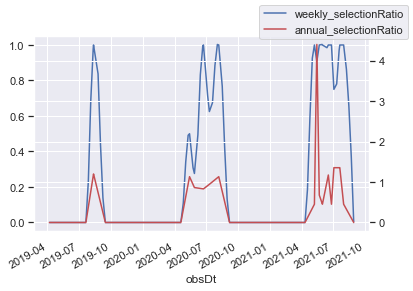

In [247]:
habSel = habSel.reset_index()
ay = habSel.plot(x='obsDt',y='weekly_selectionRatio',legend=False)
ay2 = ay.twinx()
habSel.plot(x='obsDt',y='annual_selectionRatio',ax=ay2,legend=False,color='r')
ay.figure.legend()
plt.show()

In [268]:
#standardize and prepare fpar, lai data
def feature_FparLai(habitatLabel: int,cnx=connectDB()):
	try:
		fpar_and_lai_query = f"""WITH "fparLaiSummary" as (
SELECT
	fpar.Date as "readingDate",
	fpar.Mean as "fparMean",
	(lead(fpar.Mean,1) over(order by fpar.locId desc,fpar."Date" asc)) as "fparLead",
	(lead(fpar.Mean,2) over(order by fpar.locId desc,fpar."Date" asc)) as "fparLead2",
	(lag(fpar.Mean,1) over(order by fpar.locId desc,fpar."Date" asc)) as "fparLag",
	(lag(fpar.Mean,2) over(order by fpar.locId desc,fpar."Date" asc)) as "fparLag2",
	laiMean,
	laiLead,
	laiLead2,
	laiLag,
	laiLag2,
	goodReads,
	badReads,
	deadPixels,
	fpar.locId as "locId",
	(select habitatLabel from Hotspots where Hotspots.locId=fpar.locId) as "habitatLabel"
from "MOD15A2H-006-Statistics.csv_MODIS_cooking" as fpar
left join
	(select
		leafArea.locId as "lai_locId",
		leafArea."Date" as "lai_date",
		CASE WHEN leafArea.Mean = 0.0 THEN leafArea.Mean+0.1 ELSE leafArea.Mean END as "laiMean",
		(lead(leafArea.Mean,1) over(order by leafArea.locId desc,leafArea."Date" asc)) as "laiLead",
		(lead(leafArea.Mean,2) over(order by leafArea.locId desc,leafArea."Date" asc)) as "laiLead2",
		(lag(leafArea.Mean,1) over(order by leafArea.locId desc,leafArea."Date" asc)) as "laiLag",
		(lag(leafArea.Mean,2) over(order by leafArea.locId desc,leafArea."Date" asc)) as "laiLag2"
	from "MOD15A2H-006-Statistics.csv_MODIS_cooking" as leafArea where leafArea.Dataset = 'Lai_500m' order by leafArea.locId desc,leafArea."Date" asc) 
as lai on lai.lai_locId = fpar.locId and lai.lai_date = fpar.Date
left join
	(select qaqc.locId as "qa_locId",qaqc."Date" as "qa_date",qaqc.goodReads,qaqc.badReads,qaqc."157" as "deadPixels"
	from "MOD15A2H-006-FparLai-QC-Statistics-QA.csv_MODIS_cooking" as qaqc)
as qa on qa.qa_locId=fpar.locId AND qa.qa_date=fpar.Date
where fpar.Dataset = 'Fpar_500m'
and readingDate not like '19%'
order by fpar.locId desc,readingDate asc
)
select
	readingDate,
	locId,
	habitatLabel,
	goodReads,
	badReads,
	CASE WHEN 
		laiMean-laiLead >=3 AND laiMean-laiLag >=3 THEN ((laiLead+laiLead2+laiLag2+laiLag)/4)
		when deadPixels >= goodReads and ((laiLead+laiLag)/2)!= 0 then ((laiLead+laiLead2+laiLag2+laiLag)/4)
		when badReads >=goodReads THEN ((laiLead+laiLead2+laiLag2+laiLag)/4)
		when laiMean = 0 then ((laiLead+laiLead2+laiLag2+laiLag)/4)
		else laiMean end as "adj_laiMean",
	CASE WHEN
		fparMean-fparLead >=0.3 AND fparMean-fparLag >=0.3 THEN ((fparLead+fparLead2+fparLag2+fparLag)/4)
		when deadPixels >= goodReads and ((fparLead+fparLag)/2)!=0 then ((fparLead+fparLead2+fparLag2+fparLag)/4)
		when badReads >= goodReads THEN ((fparLead+fparLead2+fparLag2+fparLag)/4)
		when fparMean = 0 then ((fparLead+fparLead2+fparLag2+fparLag)/4)
		else fparMean end as "adj_fparMean"
from fparLaiSummary
where habitatLabel = {habitatLabel}
;"""
		fparLai = pd.read_sql(sql=fpar_and_lai_query,con=cnx,parse_dates='readingDate')
	#standardize
		fparLai['adj_laiMean'] = stats.boxcox(fparLai['adj_laiMean'])[0]
		fparLai['adj_fparMean'] = stats.boxcox(fparLai['adj_fparMean'])[0]
	#summarize
		habitat_fparLai = fparLai[['readingDate','adj_fparMean','adj_laiMean']]
		habitat_fparLai = habitat_fparLai.groupby('readingDate',as_index=False).mean()
		habitat_fparLai['week_year'] = habitat_fparLai.apply(lambda y: '-'.join([str(int(y.readingDate.year)),str(int(y.readingDate.week))]),axis=1)
	except Exception as ex:
		raise ex
	return habitat_fparLai

In [269]:
fparLai = feature_FparLai(habitatLabel=2)
fparLai

,readingDate,adj_fparMean,adj_laiMean,week_year
0,2018-12-27,-0.402428,0.900110,2018-52
1,2019-01-01,-0.547526,-0.013169,2019-1
2,2019-01-09,-0.454943,0.476123,2019-2
3,2019-01-17,-0.442968,0.450236,2019-3
4,2019-01-25,-0.497896,-0.318011,2019-4
...,...,...,...,...
134,2021-11-25,-0.492995,0.000051,2021-47
135,2021-12-03,-0.447943,0.703693,2021-48
136,2021-12-11,-0.585401,0.244326,2021-49
137,2021-12-19,-0.516806,0.419904,2021-50


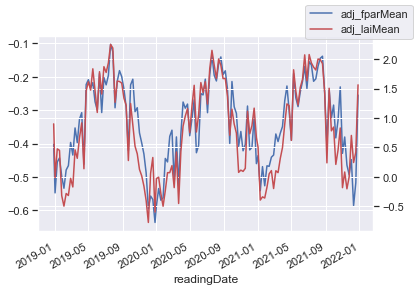

In [203]:
ax = fparLai.plot(x='readingDate',y='adj_fparMean',legend=False)
ax2 = ax.twinx()
fparLai.plot(x='readingDate',y='adj_laiMean',ax=ax2,legend=False,color='r')
ax.figure.legend()
plt.show()

In [277]:
gh = pd.concat(objs=[fparLai,habSel],)
gh.sort_values(by=['week_year'],ascending=True,inplace=True)
gh.groupby(by=['week_year'],as_index=False)